In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter
from scipy.stats import linregress
from scipy.optimize import least_squares
import numpy as np
import mplcursors
from matplotlib.widgets import TextBox

## Corriente medida por la bobina de Rogowski

Con el objetivo de adquirir la corriente producida por las descargas sin emplear una resistencia que la limite se utilizó una bobina Rogowski. En ella la tensión de salida es proporcional a la derivada de la corriente, de manera que para obtener la corriente es necesario integrar la señal medida y calibrarla con una señal conocida.
Se usó entonces una resistencia $R = (0.55 \pm 0.02)\ \Omega$ antes de la conexión a tierra en la cual se midió la caída de voltaje y a partir de la cual se obtuvo la constante de calibración $C = (2.31 \pm 0.11) \cdot 10^9\ (\Omega s)^{-1}$, propia de la bobina utilizada. Aquí hemos disminuido la constante en un 50% para que los voltajes obtenidos en el ajuste correspondieran al rango de los $1000\ V$.

La siguiente función toma el nombre de un conjunto de datos en formato _csv_ (levantados por el osciloscopio con el que se midió) y devuelve:
1. Si _plot_ es **True**, un primer gráfico en el que se muestra la señal de voltaje medido sobre la bobina en función del tiempo y misma señal suavizada usando un filtro _Savitzky-Golay_.
2. Si _plot_ es **True**, el gráfico que resulta de integrar la señal filtrada (usando la _regla del trapecio_) y multiplicar por la constante de calibración, a su vez muestra la misma señal luego de restar el fondo calculado mediante un ajuste lineal en los extremos de la señal obtenida (usando la regresión lineal de _scipy_)
3. Las variables _time_ y _backgroundless\_current_, correspondientes al tiempo y la corriente en el plasma sin el fondo.

El parámetro _sub_ indica si se trata de un subamortiguado (se observa una oscilación), caso en el cual el ajuste lineal del fondo se realiza sólo para la primera parte de la señal

In [2]:
def plot_Rogowski_signal(data_name, plot = False, sub = False):
    rogowski_data = pd.read_csv(data_name+'.csv', names=['time','voltage'])
    rogowski_data.drop(labels=[0,1,2], axis='rows', inplace=True)

    time = np.array(rogowski_data['time']).astype(np.float)
    voltage = np.array(rogowski_data['voltage']).astype(np.float)
    filtered_voltage = savgol_filter(voltage, 15, 2)
    C = 1.155*(10**9)
    current = np.array([np.trapz(filtered_voltage[:i],time[:i]) for i in range(len(voltage))])*C
    linear_time = []
    linear_intvoltage = []
    for i in range(len(time)):
        if sub:
            if time[i]<=float(min(time))+0.5*10**(-5):
                linear_time.append(time[i])
                linear_intvoltage.append(current[i])
        else:
            if time[i]<=float(min(time))+0.5*10**(-5) or time[i]>=float(max(time))-0.5*10**(-5):
                linear_time.append(time[i])
                linear_intvoltage.append(current[i])
    slope, intercept, r_value, p_value, std_err = linregress(linear_time,linear_intvoltage)
    background_adjustment = slope*np.array(time)+intercept
    backgroundless_current = current-background_adjustment
    if plot:
        fig, axs = plt.subplots(2, 1, constrained_layout=True,figsize=(10,10))
        axs[0].plot(time, voltage, label = 'Rogowski signal')
        axs[0].plot(time, filtered_voltage, label = 'Smoothed signal')
        axs[0].set_ylabel('Voltage [V]', fontsize=13)
        axs[0].set_xlabel('Time [s]', fontsize=13)
        axs[0].tick_params(axis='both', labelsize=13)
        axs[0].legend()
        axs[1].plot(time, current, label = 'Integrated voltage (current)')
        axs[1].plot(time, background_adjustment, label = 'Background adjustment')
        axs[1].plot(time, backgroundless_current, label = 'Current without background')
        axs[1].set_ylabel('Electric current [A]', fontsize=13)
        axs[1].set_xlabel('Time [s]', fontsize=13)
        axs[1].tick_params(axis='both', labelsize=13)
        axs[1].legend()
        fig.suptitle(data_name, fontsize=15)
#         plt.savefig('Current_{}.png'.format(data_name), dpi=100, format='png') #saves figure
    return time, backgroundless_current

# plot_Rogowski_signal('WaveData4312', plot=True, sub=True)


El siguiente diccionario corresponde a los datos necesarios para realizar el ajuste sobre cada conjunto de mediciones:
1. Los primeros dos elementos de la lista son los límites sobre cada conjunto de mediciones, para realizar el ajuste con la oscilación únicamente.
2. El tercer elemento corresponde al parámetro _sub_ (si es **True** se trata como un subamortiguado, con una oscilación negativa al final).
3. El último elemento corresponde al parámetro _T2_ (tiempo en que pasa por cero) para que funcione el ajuste del circuito RLC.

In [3]:
data_limits = {
    'WaveData5546':[2.380e-6,3.574e-5,True,1.894e-5],
    'WaveData5960':[-7.9e-7,3.184e-5,True,1.724e-5],
    'WaveData59100':[1.69e-6,3.184e-5,True,4.7e-6],
    'WaveData59104':[-9.5e-7,3.184e-5,True,1.742e-5],
    'WaveData59106':[6.8e-7,3.184e-5,True,1.848e-5],
    'WaveData4312':[2.98e-6,2.086e-5,False,2.086e-5],
    'WaveData4320':[2e-7,1.724e-5,False,1.6e-5],
    'WaveData4636':[2.5e-6,1.941e-5,False,1.94e-5],
    'WaveData4642':[1.05e-6,1.889e-5,False,1.88e-5],
    'WaveData4968':[2.3e-7,1.706e-5,False,1.69e-5],
    'WaveData4976':[5.93e-6,2.36e-5,False,2.3e-5],
    'WaveData5956':[8.1e-7,1.796e-5,False,4.7e-6],
    'WaveData5958':[1.57e-6,1.926e-5,False,1.92e-5],
    'WaveData5962':[2.2e-7,1.691e-5,False,1.69e-5],
    'WaveData5964':[1.83e-6,1.909e-5,False,1.9e-5],
    'WaveData7422':[-1.621e-5,-1e-8,False,-1.4e-7],
    'WaveData7426':[-1.618e-5,-1e-8,False,-4.2e-7],
    'WaveData50262':[1.13e-6,1.823e-5,False,1.82e-5],
    'WaveData50268':[4.4e-7,1.741e-5,False,1.74e-5],
    'WaveData59102':[2.18e-6,1.91e-5,False,2.3e-6],
    'WaveData59108':[4.64e-6,2.166e-5,False,5e-6],
    'WaveData59140':[-1.29e-6,1.689e-5,False,1.671e-5],
    'WaveData59142':[1e-8,1.67e-5,False,1.66e-5],
    'WaveData59144':[1e-8,1.697e-5,False,1.688e-5],
    'WaveData59146':[-1.09e-6,1.619e-5,False,1.618e-5],
    'WaveData59148':[1.8e-7,1.732e-5,False,1.724e-5],
    'WaveData59158':[2e-8,1.696e-5,False,1.69e-5],
    'WaveData59160':[-5.1e-7,1.767e-5,False,1.739e-5],
    'WaveData59162':[3.7e-7,1.742e-5,False,1.723e-5],
    'WaveData59164':[-5.9e-7,1.78e-5,False,1.7e-5],
    'WaveData65468':[-1.2e-6,1.556e-5,False,1.535e-5],
    'WaveData73100':[-1.532e-5,-1e-8,False,-5.2e-7],
    'WaveData73102':[-1.544e-5,-1e-8,False,-6.6e-7],
    'WaveData76175':[-1.54e-5,-1e-8,False,-3.2e-7],
    'WaveData76179':[-1.538e-5,-1e-8,False,-4e-8]
}

La siguiente celda corresponde al ajuste del circuito RLC sobre el conjunto de mediciones indicado en la variable _data\_name_. Retorna la tabla de parámetros hallados con sus incertezas y un gráfico del ajuste realizado.

Parámetros hallados (con incertezas):
Best Amplitude:  1884.781  ±  2.377
Best Omega:  175058.321  ±  82.622
Best Alpha:  52234.19  ±  105.882
resistencia: ( 0.3260676  ±  0.0010517 )ohm
inductancia: ( 3.1212e-06  ±  3.7e-09 )H
voltaje (para correr el modelo): 1030  V


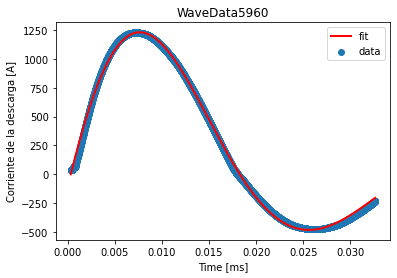

In [4]:
data_name = 'WaveData5960'

def data_to_fit(data_name, sub = None):
    time, current = plot_Rogowski_signal(data_name, sub = data_limits[data_name][2])
    data = [[time[i], current[i]] for i in range(len(time)) if (time[i]>=data_limits[data_name][0] and time[i]<=data_limits[data_name][1])]
    data = np.transpose(np.array(data))
    T2 = data_limits[data_name][3]-data[0][0]
    data[0] = np.array(data[0])-data[0][0]
    return data[0], data[1], T2

x, y, T2 = data_to_fit(data_name)

# fitting function (damped sine wave + constant)
def cos_fit_fun_damped(parameters,time):
  a = parameters[0]
  omega = parameters[1]
  alpha = parameters[2]
  t0 = parameters[3]
  y = a * np.sin(omega * (time-t0) ) * np.exp(-alpha*(time-t0)) 
  return y

def get_residuals(parameters, position_data, time_data):
  theoretical_function = cos_fit_fun_damped(parameters,time_data )
  residuals = np.abs(theoretical_function - position_data)
  return residuals

# guess parameters
def parameter_guessing(x,y,T2):
    T1 = x[0]
    Amp1 = max(y)
    R=0.3
    L=0.000002
    guess_amplitude = Amp1 
    guess_omega = np.pi/(T2-T1) 
    guess_alpha = R/(2*L)
    guess_t0 = T1
    guess_parameters = [guess_amplitude, guess_omega, guess_alpha, guess_t0]
    return guess_parameters

# performing the fit
res_lsq = least_squares(get_residuals, parameter_guessing(x,y,T2), args=(y,x))

# fit results
best_parameters = res_lsq['x']
fitted_function = cos_fit_fun_damped(best_parameters, x)

# calculating covariance matrix (pcov)
def calcular_cov(res,y_datos):
    U, S, V = np.linalg.svd(res.jac, full_matrices=False)
    threshold = np.finfo(float).eps * max(res.jac.shape) * S[0]
    S = S[S > threshold]
    V = V[:S.size]
    pcov = np.dot(V.T / S**2, V)

    s_sq = 2 * res.cost / (y_datos.size - res.x.size)
    pcov = pcov * s_sq
    return pcov
pcov = calcular_cov(res_lsq,y)

# calculating standard deviation of RLC parameters
pstd = np.sqrt(np.diag(pcov))

# defining function to perform all calculations
def get_RLC_params(data_name):
    x, y, T2 = data_to_fit(data_name)
    res_lsq = least_squares(get_residuals, parameter_guessing(x,y,T2), args=(y,x))
    best_parameters = res_lsq['x']
    fitted_function = cos_fit_fun_damped(best_parameters, x)
    pcov = calcular_cov(res_lsq,y)
    pstd = np.sqrt(np.diag(pcov))
    Amplitude = [round(best_parameters[0],3),round(pstd[0],3)]
    Omega = [round(best_parameters[1],3),round(pstd[1],3)]
    Alpha = [round(best_parameters[2],3),round(pstd[2],3)]
    C=9.6*10**(-6)
    W02=(best_parameters[1]**2+best_parameters[2]**2)
    L=1/(C*W02)
    deltaW02=2*best_parameters[1]*pstd[1]+2*best_parameters[2]*pstd[2]
    deltaL=(deltaW02/W02)*L
    R=best_parameters[2]*2*L
    deltaR=(pstd[2]/best_parameters[2]+deltaL/L)*R
    Resistance = [round(R,7),round(deltaR,7)]
    Inductance = [round(L,10),round(deltaL,10)]
    Omega0 = [round(W02,1),round(deltaW02,1)]
    Voltage = best_parameters[0]*best_parameters[1]*L
    return Amplitude, Omega, Omega0, Alpha, Resistance, Inductance, Voltage

# printing parameters
print('Parámetros hallados (con incertezas):')
print('Best Amplitude: ',round(best_parameters[0],3),' ± ',round(pstd[0],3))
print('Best Omega: ' ,round(best_parameters[1],3),' ± ',round(pstd[1],3))
print('Best Alpha: ' ,round(best_parameters[2],3),' ± ',round(pstd[2],3))
C=9.6*10**(-6) #capacidad en faradios
W02=(best_parameters[1]**2+best_parameters[2]**2)
L=1/(C*W02)
deltaW02=2*best_parameters[1]*pstd[1]+2*best_parameters[2]*pstd[2]
deltaL=(deltaW02/W02)*L
R=best_parameters[2]*2*L
deltaR=(pstd[2]/best_parameters[2]+deltaL/L)*R
print("resistencia: (", round(R,7),' ± ',round(deltaR,7),')ohm')
print("inductancia: (", round(L,10),' ± ',round(deltaL,10),')H')
print("voltaje (para correr el modelo):",  round(best_parameters[0]*best_parameters[1]*L)," V")

# deleting negative part of fit
time = []
current = []
RLC = []
for i in range(len(x)):
    if (i<len(x)/2 and fitted_function[i]>=0) or i>=len(x)/2:
        time.append(x[i])
        current.append(y[i])
        RLC.append(fitted_function[i])
# plotting results
plt.figure(2)
plt.scatter(np.array(time)*1000, current,  label='data')
plt.plot(np.array(time)*1000, RLC, color = 'red', linewidth = 2.0, label='fit')
plt.xlabel("Time [ms]")
plt.ylabel("Corriente de la descarga [A]")
plt.title(data_name)
plt.legend()
# plt.savefig('Configuración 1 sin campo/RLC_{}.png'.format(data_name), dpi=100, format='png') #saves figure
plt.show()


En la siguiente celda (en las líneas comentadas) construimos una tabla con los parámteros obtenidos para cada ajuste y la guardamos en un csv. En las siguientes líneas lo importamos y mostramos en el output.

In [ ]:
# Names = []
# Amplitudes = []
# Omegas = []
# Alphas = []
# Resistances = []
# Inductances = []
# dAmplitudes = []
# dOmegas = []
# dAlphas = []
# dResistances = []
# dInductances = []
# Cocientes = []
# Omegas0 = []
# dOmegas0 = []
# Voltages = []

# for data in data_limits:
#     Names.append(data)
#     Amplitude, Omega, Omega0, Alpha, Resistance, Inductance, Voltage = get_RLC_params(data)
#     Amplitudes.append(Amplitude[0])
#     dAmplitudes.append(Amplitude[1])
#     Omegas.append(Omega[0])
#     dOmegas.append(Omega[1])
#     Omegas0.append(Omega0[0])
#     dOmegas0.append(Omega0[1])
#     Alphas.append(Alpha[0])
#     dAlphas.append(Alpha[1])
#     Resistances.append(Resistance[0])
#     dResistances.append(Resistance[1])
#     Inductances.append(Inductance[0])
#     dInductances.append(Inductance[1])
#     Voltages.append(Voltage)

# param_dict = {'Name':Names,'Amplitude':Amplitudes,'dAmplitude':dAmplitudes,'Omega':Omegas,'dOmega':dOmegas,'Omega0':Omegas0,'dOmega0':dOmegas0,'Alpha':Alphas,'dAlpha':dAlphas,'Resistance':Resistances,'dResistance':dResistances,'Inductance':Inductances,'dInductance':dInductances,'Voltage':Voltages}

# parameters = pd.DataFrame(data=param_dict)
# parameters.to_csv('Códigos/parameters_table.csv', index=False)

parameters = pd.read_csv('Códigos/parameters_table.csv')
parameters.style

# lineas para calcular minimos, maximos y valores medios de los ajustes
# print('resistencia min: '+str(min(parameters['Resistance'])))
# print('resistencia max: '+str(max(parameters['Resistance'])))
# print('resistencia media: '+str(sum(parameters['Resistance'])/len(parameters['Resistance'])))
# print('inductancia min: '+str(min(parameters['Inductance'])))
# print('inductancia max: '+str(max(parameters['Inductance'])))
# print('inductancia media: '+str(sum(parameters['Inductance'])/len(parameters['Inductance'])))




### Visualizar simulaciones

In [ ]:
def simulated_time(data_name, plot = False):
    # get measured time and current
    mes_time, mes_current, T2 = data_to_fit(data_name)

    # dataframes
    perfilestemp = pd.read_csv("Configuración 1 sin campo/perfiles_temp_{}.txt".format(data_name), sep = ' ', engine='python')

    # PERFILES TEMP
    sim_time = []
    sim_current = []
    sim_Ibit = []
    sim_R = []
    sim_thrust = []
    sim_mass = []
    sim_lorentz = []
    for index, row in perfilestemp.iterrows():
        sim_time.append(row['Unnamed: 3'])
        if row['Unnamed: 4']<0:
            sim_current.append(row['Vcap'])
            sim_Ibit.append(row['Unnamed: 12'])
            sim_R.append(row['Unnamed: 8'])
            sim_thrust.append(row['Unnamed: 14'])
            sim_mass.append(row['res_plasma'])
            sim_lorentz.append(row['Unnamed: 20'])
        else:
            sim_current.append(row['Unnamed: 7'])
            sim_Ibit.append(row['Unnamed: 13'])
            sim_R.append(row['Unnamed: 9'])
            sim_thrust.append(row['Unnamed: 15'])
            sim_mass.append(row['Unnamed: 17'])
            sim_lorentz.append(row['Velec'])

    if plot:
        # plot
        fig, axs = plt.subplots(5, 1, constrained_layout=True,figsize=(10,10))
        axs[0].plot(sim_time, sim_current, label = 'simulated data')
        axs[0].plot(mes_time, mes_current, label = 'measured data')
        axs[0].set_ylabel('Corriente [A]', fontsize=13)
        axs[0].set_xlabel('Tiempo [s]', fontsize=13)
        axs[0].tick_params(axis='both', labelsize=13)
        axs[0].legend()
        axs[1].plot(sim_time, sim_Ibit, label = 'Ibit')
        axs[1].set_ylabel('Impulso [Ns]', fontsize=13)
        axs[1].set_xlabel('Tiempo [s]', fontsize=13)
        axs[1].tick_params(axis='both', labelsize=13)
        axs[1].legend()
        axs[2].plot(sim_time, sim_R, label = 'Resistance')
        axs[2].set_ylabel('Resistencia [Ohm]', fontsize=13)
        axs[2].set_xlabel('Tiempo [s]', fontsize=13)
        axs[2].tick_params(axis='both', labelsize=13)
        axs[2].legend()
        axs[3].plot(sim_time, sim_thrust, label = 'Thrust')
        axs[3].plot(sim_time, sim_lorentz, label = 'Lorentz')
        axs[3].set_ylabel('Fuerza [N]', fontsize=13)
        axs[3].set_xlabel('Tiempo [s]', fontsize=13)
        axs[3].tick_params(axis='both', labelsize=13)
        axs[3].legend()
        axs[4].plot(sim_time, sim_mass, label = 'Mass')
        axs[4].set_ylabel('Masa [kg]', fontsize=13)
        axs[4].set_xlabel('Tiempo [s]', fontsize=13)
        axs[4].tick_params(axis='both', labelsize=13)
        axs[4].legend()
        fig.suptitle(data_name, fontsize=15)
#         plt.savefig('Configuración 1 sin campo/Time_{}.png'.format(data_name), dpi=100, format='png') #saves figure

    maximum_current = max(sim_current)
    maximum_index = sim_current.index(maximum_current)
    return [maximum_current,sim_Ibit[maximum_index],sim_R[maximum_index],sim_thrust[maximum_index],sim_mass[maximum_index],sim_lorentz[maximum_index]]


# for data in data_limits:
#     simulated_time(data,plot=True)


In [ ]:
def simulated_position(data_name, plot = False):
    # perfil X
    perfiles1 = pd.read_csv("Configuración 1 sin campo/perfiles1_{}.txt".format(data_name), header=1, sep = '  ', engine='python')

    x = list(perfiles1['x [m]'])
    rho = list(perfiles1[' rho [kg/m**3]'])
    u = list(perfiles1[' u [m/s]'])
    T = list(perfiles1[' T [eV]'])
    ne = list(perfiles1['ne[m**-3]'])

    if plot:
        fig, axs = plt.subplots(4, 1, constrained_layout=True,figsize=(10,10))
        axs[0].plot(x, u, label = 'u')
        axs[0].set_ylabel('Velocidad [m/s]', fontsize=13)
        axs[0].set_xlabel('Posición [m]', fontsize=13)
        axs[0].tick_params(axis='both', labelsize=13)
        axs[0].legend()
        axs[1].plot(x, T, label = 'T')
        axs[1].set_ylabel('Temperatura [eV]', fontsize=13)
        axs[1].set_xlabel('Posición [m]', fontsize=13)
        axs[1].tick_params(axis='both', labelsize=13)
        axs[1].legend()
        axs[2].plot(x, ne, label = 'ne')
        axs[2].set_ylabel('ne [1/m^3]', fontsize=13)
        axs[2].set_xlabel('Posición [m]', fontsize=13)
        axs[2].tick_params(axis='both', labelsize=13)
        axs[2].legend()
        axs[3].plot(x, rho, label = 'rho')
        axs[3].set_ylabel('rho [kg/m^3]', fontsize=13)
        axs[3].set_xlabel('Posición [m]', fontsize=13)
        axs[3].tick_params(axis='both', labelsize=13)
        axs[3].legend()
        fig.suptitle(data_name, fontsize=15)
#         plt.savefig('Configuración 1 sin campo/Position_{}.png'.format(data_name), dpi=100, format='png') #saves figure
    return [u[-1],T[-1],ne[-1],rho[-1]]
    
# for data in data_limits:
#     simulated_position(data,plot=True)
    

En la siguiente se guardan los parámetros simulados para cada conjunto de datos en función del tiempo para el tiempo de la corriente máxima y los parámetros en función de la posición para el extremo del modelo (lugar más cercano al que fue medido empíricamente).

In [6]:
# Name = []
# Current = []
# Ibit = []
# Resistance = []
# Thrust = []
# Mass = []
# Lorentz = []
# u = []
# T = []
# ne = []
# rho = []

# for data in data_limits:
#     time = simulated_time(data)
#     position = simulated_position(data)
#     Name.append(data)
#     Current.append(time[0])
#     Ibit.append(time[1])
#     Resistance.append(time[2])
#     Thrust.append(time[3])
#     Mass.append(time[4])
#     Lorentz.append(time[5])
#     u.append(position[0])
#     T.append(position[1])
#     ne.append(position[2])
#     rho.append(position[3])

# sim_max_dict = {'Name':Name,'Current':Current,'Ibit':Ibit,'Resistance':Resistance,'Thrust':Thrust,'Mass':Mass,'Lorentz':Lorentz,'u':u,'T':T,'ne':ne,'rho':rho}

# sim_max = pd.DataFrame(data=sim_max_dict)
# sim_max.to_csv('Códigos/sim_max_table.csv', index=False)

sim_max = pd.read_csv('Códigos/sim_max_table.csv')

sim_max.style

# lineas para calcular valores medios de los parámetros
# print('fuerza media: '+str(sum(sim_max['Thrust'])/len(sim_max['Thrust']))+'+-'+str(np.std(sim_max['Thrust'])))
# print('Ibit medio: '+str(sum(sim_max['Ibit'])/len(sim_max['Ibit']))+'+-'+str(np.std(sim_max['Ibit'])))
# print('masa media: '+str(sum(sim_max['Mass'])/len(sim_max['Mass']))+'+-'+str(np.std(sim_max['Mass'])))
# print('velocidad media: '+str(sum(sim_max['u'])/len(sim_max['u']))+'+-'+str(np.std(sim_max['u'])))
# print('temperatura media: '+str(sum(sim_max['T'])/len(sim_max['T']))+'+-'+str(np.std(sim_max['T'])))
# print('densidad electronica media: '+str(sum(sim_max['ne'])/len(sim_max['ne']))+'+-'+str(np.std(sim_max['ne'])))

# lineas para calcular el minimo, maximo y valor medio de las corrientes
# print('minimo: '+str(min(sim_max['Current'])))
# print('maximo: '+str(max(sim_max['Current'])))
# print('valor medio: '+str(sum(sim_max['Current'])/len(sim_max['Current'])))


minimo: 504.12768647806604
maximo: 1312.6428569433901
valor medio: 1017.6278814880867


La siguiente celda grafica los parámetros simulados para cada conjunto de datos en función de la corriente máxima correspondiente, toma los parámetros en función del tiempo para el tiempo de la corriente máxima y los parámetros en función de la posición para el extremo del modelo (lugar más cercano al que fue medido empíricamente).

In [ ]:
fig, axs = plt.subplots(4, 1, constrained_layout=True,figsize=(10,10))
axs[0].scatter(sim_max['Current'], sim_max['Ibit'], label = 'Ibit')
axs[0].set_ylabel('Impulso [Ns]', fontsize=13)
axs[0].set_xlabel('Corriente [A]', fontsize=13)
axs[0].tick_params(axis='both', labelsize=13)
axs[0].legend()
axs[1].scatter(sim_max['Current'], sim_max['Resistance'], label = 'Resistance')
axs[1].set_ylabel('Resistencia [Ohm]', fontsize=13)
axs[1].set_xlabel('Corriente [A]', fontsize=13)
axs[1].tick_params(axis='both', labelsize=13)
axs[1].legend()
axs[2].scatter(sim_max['Current'], sim_max['Thrust'], label = 'Thrust')
axs[2].scatter(sim_max['Current'], sim_max['Lorentz'], label = 'Lorentz')
axs[2].set_ylabel('Fuerza [N]', fontsize=13)
axs[2].set_xlabel('Corriente [A]', fontsize=13)
axs[2].tick_params(axis='both', labelsize=13)
axs[2].legend()
axs[3].scatter(sim_max['Current'], sim_max['Mass'], label = 'Mass')
axs[3].set_ylabel('Masa [kg]', fontsize=13)
axs[3].set_xlabel('Corriente [A]', fontsize=13)
axs[3].tick_params(axis='both', labelsize=13)
axs[3].legend()
# plt.savefig('Configuración 1 sin campo/Correlated_time.png', dpi=100, format='png') #saves figure


fig, axs = plt.subplots(4, 1, constrained_layout=True,figsize=(10,10))
axs[0].scatter(sim_max['Current'], sim_max['u'], label = 'u')
axs[0].set_ylabel('Velocidad [m/s]', fontsize=13)
axs[0].set_xlabel('Corriente [A]', fontsize=13)
axs[0].tick_params(axis='both', labelsize=13)
axs[0].legend()
axs[1].scatter(sim_max['Current'], sim_max['T'], label = 'T')
axs[1].set_ylabel('Temperatura [eV]', fontsize=13)
axs[1].set_xlabel('Corriente [A]', fontsize=13)
axs[1].tick_params(axis='both', labelsize=13)
axs[1].legend()
axs[2].scatter(sim_max['Current'], sim_max['ne'], label = 'ne')
axs[2].set_ylabel('ne [m**-3]', fontsize=13)
axs[2].set_xlabel('Corriente [A]', fontsize=13)
axs[2].tick_params(axis='both', labelsize=13)
axs[2].legend()
axs[3].scatter(sim_max['Current'], sim_max['rho'], label = 'rho')
axs[3].set_ylabel('rho [kg/m^3]', fontsize=13)
axs[3].set_xlabel('Corriente [A]', fontsize=13)
axs[3].tick_params(axis='both', labelsize=13)
axs[3].legend()
# plt.savefig('Configuración 1 sin campo/Correlated_position.png', dpi=100, format='png') #saves figure


### Simulaciones con campo para comparar WaveData4312

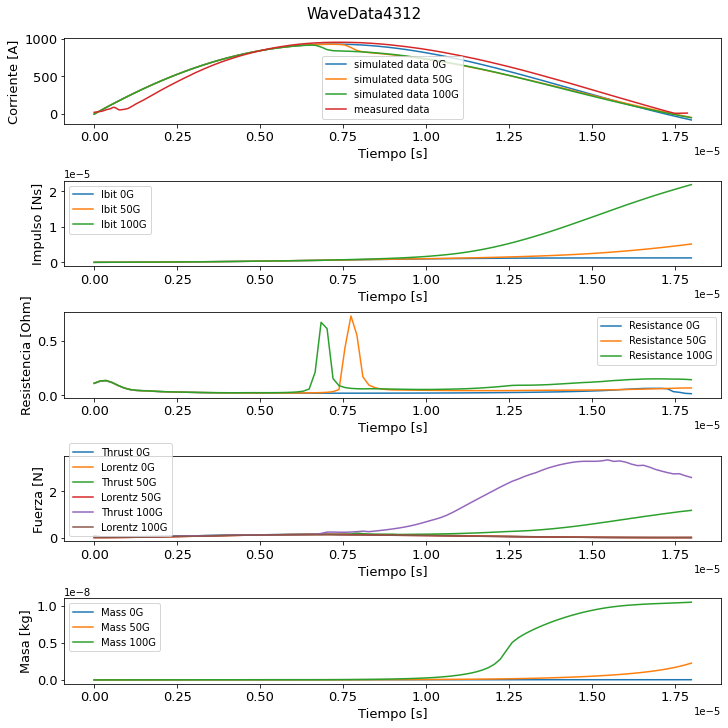

In [10]:
data_name = 'WaveData4312'

# get measured time and current
mes_time, mes_current, T2 = data_to_fit(data_name)

# dataframes
perfilestemp = pd.read_csv("Campo roto/perfiles_temp_{}_sincampo.txt".format(data_name), sep = ' ', engine='python')
perfilestemp100 = pd.read_csv("Campo roto/perfiles_temp_{}_campo100.txt".format(data_name), sep = ' ', engine='python')
perfilestemp50 = pd.read_csv("Campo roto/perfiles_temp_{}_campo50.txt".format(data_name), sep = ' ', engine='python')
    
    
# PERFILES TEMP
sim_time = []
sim_current = []
sim_Ibit = []
sim_R = []
sim_thrust = []
sim_mass = []
sim_lorentz = []
sim_current100 = []
sim_Ibit100 = []
sim_R100 = []
sim_thrust100 = []
sim_mass100 = []
sim_lorentz100 = []
sim_current50 = []
sim_Ibit50 = []
sim_R50 = []
sim_thrust50 = []
sim_mass50 = []
sim_lorentz50 = []
for index, row in perfilestemp.iterrows():
    sim_time.append(row['Unnamed: 3'])
    if row['Unnamed: 4']<0 and index<=95:
        sim_current.append(row['Vcap'])
        sim_Ibit.append(row['Unnamed: 12'])
        sim_R.append(row['Unnamed: 8'])
        sim_thrust.append(row['Unnamed: 14'])
        sim_mass.append(row['res_plasma'])
        sim_lorentz.append(row['Unnamed: 20'])
    elif index>95:
        sim_current.append(row['Unnamed: 5'])
        sim_Ibit.append(row['Unnamed: 10'])
        sim_R.append(row['Unnamed: 7'])
        sim_thrust.append(row['Unnamed: 12'])
        sim_mass.append(row['Unnamed: 14'])
        sim_lorentz.append(row['Unnamed: 18'])
    else:
        sim_current.append(row['Unnamed: 7'])
        sim_Ibit.append(row['Unnamed: 13'])
        sim_R.append(row['Unnamed: 9'])
        sim_thrust.append(row['Unnamed: 15'])
        sim_mass.append(row['Unnamed: 17'])
        sim_lorentz.append(row['Velec'])
for index, row in perfilestemp100.iterrows():
    if row['Unnamed: 4']<0 and index<=96:
        sim_current100.append(row['Vcap'])
        sim_Ibit100.append(row['Unnamed: 12'])
        sim_R100.append(row['Unnamed: 8'])
        sim_thrust100.append(row['Unnamed: 14'])
        sim_mass100.append(row['res_plasma'])
        sim_lorentz100.append(row['Unnamed: 20'])
    elif index>96:
        sim_current100.append(row['Unnamed: 5'])
        sim_Ibit100.append(row['Unnamed: 10'])
        sim_R100.append(row['Unnamed: 7'])
        sim_thrust100.append(row['Unnamed: 12'])
        sim_mass100.append(row['Unnamed: 14'])
        sim_lorentz100.append(row['Unnamed: 18'])
    else:
        sim_current100.append(row['Unnamed: 7'])
        sim_Ibit100.append(row['Unnamed: 13'])
        sim_R100.append(row['Unnamed: 9'])
        sim_thrust100.append(row['Unnamed: 15'])
        sim_mass100.append(row['Unnamed: 17'])
        sim_lorentz100.append(row['Velec'])
for index, row in perfilestemp50.iterrows():
    if row['Unnamed: 4']<0 and index<=97:
        sim_current50.append(row['Vcap'])
        sim_Ibit50.append(row['Unnamed: 12'])
        sim_R50.append(row['Unnamed: 8'])
        sim_thrust50.append(row['Unnamed: 14'])
        sim_mass50.append(row['res_plasma'])
        sim_lorentz50.append(row['Unnamed: 20'])
    elif index>97:
        sim_current50.append(row['Unnamed: 5'])
        sim_Ibit50.append(row['Unnamed: 10'])
        sim_R50.append(row['Unnamed: 7'])
        sim_thrust50.append(row['Unnamed: 12'])
        sim_mass50.append(row['Unnamed: 14'])
        sim_lorentz50.append(row['Unnamed: 18'])
    else:
        sim_current50.append(row['Unnamed: 7'])
        sim_Ibit50.append(row['Unnamed: 13'])
        sim_R50.append(row['Unnamed: 9'])
        sim_thrust50.append(row['Unnamed: 15'])
        sim_mass50.append(row['Unnamed: 17'])
        sim_lorentz50.append(row['Velec'])

# plot
fig, axs = plt.subplots(5, 1, constrained_layout=True,figsize=(10,10))
axs[0].plot(sim_time, sim_current, label = 'simulated data 0G')
axs[0].plot(sim_time, sim_current50, label = 'simulated data 50G')
axs[0].plot(sim_time, sim_current100, label = 'simulated data 100G')
axs[0].plot(mes_time, mes_current, label = 'measured data')
axs[0].set_ylabel('Corriente [A]', fontsize=13)
axs[0].set_xlabel('Tiempo [s]', fontsize=13)
axs[0].tick_params(axis='both', labelsize=13)
axs[0].legend()
axs[1].plot(sim_time, sim_Ibit, label = 'Ibit 0G')
axs[1].plot(sim_time, sim_Ibit50, label = 'Ibit 50G')
axs[1].plot(sim_time, sim_Ibit100, label = 'Ibit 100G')
axs[1].set_ylabel('Impulso [Ns]', fontsize=13)
axs[1].set_xlabel('Tiempo [s]', fontsize=13)
axs[1].tick_params(axis='both', labelsize=13)
axs[1].legend()
axs[2].plot(sim_time, sim_R, label = 'Resistance 0G')
axs[2].plot(sim_time, sim_R50, label = 'Resistance 50G')
axs[2].plot(sim_time, sim_R100, label = 'Resistance 100G')
axs[2].set_ylabel('Resistencia [Ohm]', fontsize=13)
axs[2].set_xlabel('Tiempo [s]', fontsize=13)
axs[2].tick_params(axis='both', labelsize=13)
axs[2].legend()
axs[3].plot(sim_time, sim_thrust, label = 'Thrust 0G')
axs[3].plot(sim_time, sim_lorentz, label = 'Lorentz 0G')
axs[3].plot(sim_time, sim_thrust50, label = 'Thrust 50G')
axs[3].plot(sim_time, sim_lorentz50, label = 'Lorentz 50G')
axs[3].plot(sim_time, sim_thrust100, label = 'Thrust 100G')
axs[3].plot(sim_time, sim_lorentz100, label = 'Lorentz 100G')
axs[3].set_ylabel('Fuerza [N]', fontsize=13)
axs[3].set_xlabel('Tiempo [s]', fontsize=13)
axs[3].tick_params(axis='both', labelsize=13)
axs[3].legend()
axs[4].plot(sim_time, sim_mass, label = 'Mass 0G')
axs[4].plot(sim_time, sim_mass50, label = 'Mass 50G')
axs[4].plot(sim_time, sim_mass100, label = 'Mass 100G')
axs[4].set_ylabel('Masa [kg]', fontsize=13)
axs[4].set_xlabel('Tiempo [s]', fontsize=13)
axs[4].tick_params(axis='both', labelsize=13)
axs[4].legend()
fig.suptitle(data_name, fontsize=15)
# plt.savefig('Campo roto/Time_{}.png'.format(data_name), dpi=100, format='png') #saves figure


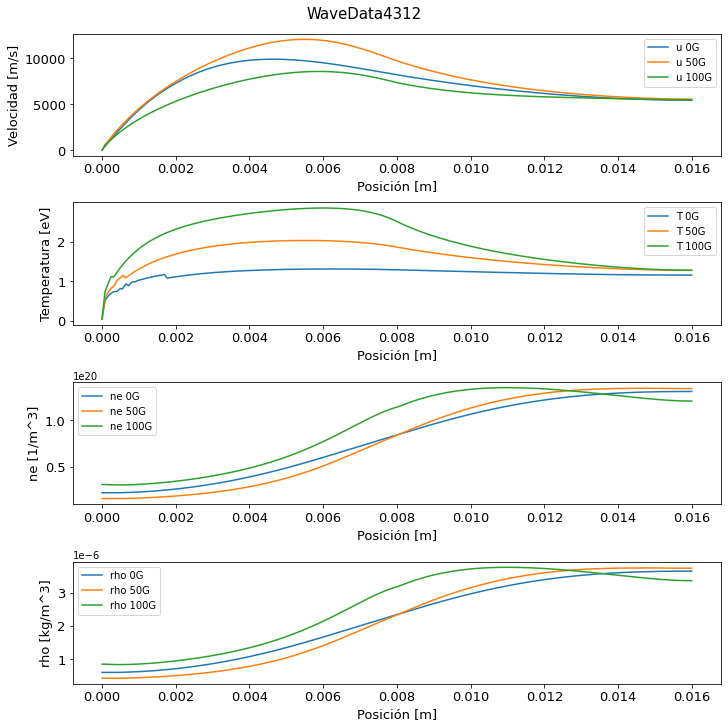

In [11]:
data_name = 'WaveData4312'

# perfil X
perfiles1 = pd.read_csv("Campo roto/perfiles1_{}_sincampo.txt".format(data_name), header=1, sep = '  ', engine='python')
perfiles1100 = pd.read_csv("Campo roto/perfiles1_{}_campo100.txt".format(data_name), header=1, sep = '  ', engine='python')
perfiles150 = pd.read_csv("Campo roto/perfiles1_{}_campo50.txt".format(data_name), header=1, sep = '  ', engine='python')

x = list(perfiles1['x [m]'])
rho = list(perfiles1[' rho [kg/m**3]'])
u = list(perfiles1[' u [m/s]'])
T = list(perfiles1[' T [eV]'])
ne = list(perfiles1['ne[m**-3]'])

rho100 = list(perfiles1100[' rho [kg/m**3]'])
u100 = list(perfiles1100[' u [m/s]'])
T100 = list(perfiles1100[' T [eV]'])
ne100 = list(perfiles1100['ne[m**-3]'])

rho50 = list(perfiles150[' rho [kg/m**3]'])
u50 = list(perfiles150[' u [m/s]'])
T50 = list(perfiles150[' T [eV]'])
ne50 = list(perfiles150['ne[m**-3]'])

fig, axs = plt.subplots(4, 1, constrained_layout=True,figsize=(10,10))
axs[0].plot(x, u, label = 'u 0G')
axs[0].plot(x, u50, label = 'u 50G')
axs[0].plot(x, u100, label = 'u 100G')
axs[0].set_ylabel('Velocidad [m/s]', fontsize=13)
axs[0].set_xlabel('Posición [m]', fontsize=13)
axs[0].tick_params(axis='both', labelsize=13)
axs[0].legend()
axs[1].plot(x, T, label = 'T 0G')
axs[1].plot(x, T50, label = 'T 50G')
axs[1].plot(x, T100, label = 'T 100G')
axs[1].set_ylabel('Temperatura [eV]', fontsize=13)
axs[1].set_xlabel('Posición [m]', fontsize=13)
axs[1].tick_params(axis='both', labelsize=13)
axs[1].legend()
axs[2].plot(x, ne, label = 'ne 0G')
axs[2].plot(x, ne50, label = 'ne 50G')
axs[2].plot(x, ne100, label = 'ne 100G')
axs[2].set_ylabel('ne [1/m^3]', fontsize=13)
axs[2].set_xlabel('Posición [m]', fontsize=13)
axs[2].tick_params(axis='both', labelsize=13)
axs[2].legend()
axs[3].plot(x, rho, label = 'rho 0G')
axs[3].plot(x, rho50, label = 'rho 50G')
axs[3].plot(x, rho100, label = 'rho 100G')
axs[3].set_ylabel('rho [kg/m^3]', fontsize=13)
axs[3].set_xlabel('Posición [m]', fontsize=13)
axs[3].tick_params(axis='both', labelsize=13)
axs[3].legend()
fig.suptitle(data_name, fontsize=15)
# plt.savefig('Campo roto/Position_{}.png'.format(data_name), dpi=100, format='png') #saves figure
    

La siguiente función fue utilizada para definir, de a un conjunto de datos a la vez, los límites establecidos para el ajuste en cada caso. Los primeros elementos del diccionario definido como _data_limits_ son el resultado de su uso.

In [ ]:
# %matplotlib notebook
# def choose_current_limits(data_name, sub = False):
    
#     time, current = plot_Rogowski_signal(data_name, sub = sub)

#     plt.plot(time, current, '.')
#     mplcursors.cursor(hover=True)

# choose_current_limits("WaveData59106", sub = True)
